
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase2<br>
    Soft Actor Critic<br>
<font color=696880 size=4>
    Ali Najar-Mohmmad Shafizade-Armin Khosravi


<font size=5 color=cyan> Names: 

Mohammad Parsa Sadeghi

Matin Zareh Bidaki

</font>
<font size=5 color=cyan> Student Numbers: </font>


401109947

401100166






In this notebook, we are going to get familiar with SAC algorithm. Soft Actor Critic (SAC) is an off-policy algorithm that maximizes a combination of expected return **and** entropy. Higher entropy results in higher exploration, which is an important concept in Reinforcement Learning.

## 📦 Setup and Dependencies

Install PyBullet for Physics based environments.

In [1]:
!pip install -q pybullet Box2D
!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 91.1 MB/s eta 0:00:00
Sat Sep 13 12:40:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       0MiB /  16384MiB |      

Import necessary packages.

In [2]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.distributions import Normal

import warnings
warnings.filterwarnings('ignore')
from gym.wrappers import RecordVideo
import gym
import pybullet_envs
np.bool8 = np.bool_
from tqdm.notebook import trange
from IPython.display import Video

# GPU/backends performance tweaks (safe no-ops on CPU)
if T.cuda.is_available():
    try:
        T.set_float32_matmul_precision('high')
    except Exception:
        pass
    try:
        T.backends.cuda.matmul.allow_tf32 = True
        T.backends.cudnn.allow_tf32 = True
    except Exception:
        pass
T.backends.cudnn.benchmark = True

## 📈 Utility codes

We will use this utility function to visualize the training progress.

In [3]:
def plot_learning_curve(x, filename, save_plot=True):
    avg_x = [np.mean(x[np.max([0, i - 100]):i]) for i in range(len(x))]
    plt.figure(dpi=200)
    plt.title('Learning Curve')
    plt.plot(range(len(x)), x, label='score', alpha=0.3)
    plt.plot(range(len(avg_x)), avg_x, label='average score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    if save_plot:
        plt.savefig(filename + '.png')
    plt.show()

This class implements a **Replay Buffer** to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1}, d_t)$ to break correlation in updates for stability in mini-batch stochastic gradient descent.


In [4]:
class ReplayBuffer:
    def __init__(self, buffer_size, state_dims, action_dims):
        self.buffer_size = buffer_size
        self.ptr = 0
        self.is_full = False

        # Initialize buffer arrays to store states, next states, actions, rewards, and done flags
        self.states = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.actions = np.zeros((buffer_size, action_dims), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.states_ = np.zeros((buffer_size, state_dims), dtype=np.float32)
        self.done = np.zeros(buffer_size, dtype=np.bool_)

    def store_transition(self, state, action, reward, state_, done):
        # Store the transition in the replay buffer
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.states_[self.ptr] = state_
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.buffer_size
        if self.ptr == 0:
            self.is_full = True

    def load_batch(self, batch_size):
        # Sample a random batch of transitions from the buffer
        max_mem = self.buffer_size if self.is_full else self.ptr
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.states[batch]
        actions = self.actions[batch]
        rewards = self.rewards[batch]
        states_ = self.states_[batch]
        done = self.done[batch]

        return states, actions, rewards, states_, done

## 🧱 Neural Networks

This cell defines three core neural networks used in SAC:

- **Critic Network:**
Estimates the **Q-value function** $ Q(s, a) $. Two critics are used to mitigate overestimation bias.

- **Value Network:**
Estimates the **state value function** $ V(s) $, used to train the actor and as a baseline.

- **Actor Network:**
Outputs the **mean** and **standard deviation** for a Gaussian policy
$
\pi(a|s) = \mathcal{N}(\mu(s), \sigma(s))
$.

In [5]:
class Critic(nn.Module):
    def __init__(self, beta, state_dims, action_dims, fc1_dims, fc2_dims, name='Critic', ckpt_dir='tmp'):
        super(Critic, self).__init__()
        
        # TODO 1: Save input arguments as attributes
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        
        # TODO 2: Define the first fully connected layer
        # The input is the concatenation of state and action
        self.fc1 = nn.Linear(state_dims + action_dims, fc1_dims)
        
        # TODO 3: Define the second hidden layer and the final Q-value output layer
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        # TODO 4: Define the optimizer. Assign to the correct device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=beta)


    def forward(self, state, action):
        x = T.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q = self.q(x)
        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Actor(nn.Module):
    def __init__(self, alpha, state_dims, action_dims, fc1_dims, fc2_dims, max_action, reparam_noise,
                 name='Actor', ckpt_dir='tmp'):        
        super(Actor, self).__init__()
        # TODO 1: Store initialization parameters
        self.alpha = alpha
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.max_action = max_action
        self.reparam_noise = reparam_noise
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)

        # TODO 2: Define fully connected layers to transform input state
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        
        # TODO 3: Output mean and standard deviation for the Gaussian policy
        self.mu = nn.Linear(fc2_dims, action_dims)
        self.sigma = nn.Linear(fc2_dims, action_dims)
        
        # TODO 4: Define optimizer and move model to the appropriate device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)


    def forward(self, state):
        #TODO        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        # Use softplus to ensure strictly positive std; add small epsilon to avoid zero
        sigma = F.softplus(self.sigma(x)) + self.reparam_noise
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        # TODO 7: Use the actor to compute distribution parameters
        mu, sigma = self.forward(state)
        
        # TODO 8: Create a normal distribution and sample from it
        probabilities = Normal(mu, sigma)
        if reparameterize:
            actions = probabilities.rsample()
        else:
            actions = probabilities.sample()
        
        squashed = T.tanh(actions)
        action = squashed * self.max_action
        log_probs = probabilities.log_prob(actions)
        log_probs -= T.log(1 - squashed.pow(2) + self.reparam_noise)
        log_probs = log_probs.sum(1, keepdim=True)

        return action, log_probs

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))


class Value(nn.Module):
    def __init__(self, beta, state_dims, fc1_dims, fc2_dims, name='Value', ckpt_dir='tmp'):
        super(Value, self).__init__()
        
        # TODO 1: Save arguments as instance variables
        self.beta = beta
        self.state_dims = state_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.name = name
        self.ckpt_dir = ckpt_dir
        self.ckpt_path = os.path.join(ckpt_dir, name)
        
        # TODO 2: Define the fully connected layers for value approximation
        self.fc1 = nn.Linear(state_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.v = nn.Linear(fc2_dims, 1)

        # TODO 3: Set optimizer and device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=beta)


    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        v = self.v(x)
        return v

    def save_checkpoint(self):
        T.save(self.state_dict(), self.ckpt_path)

    def load_checkpoint(self, gpu_to_cpu=False):
        if gpu_to_cpu:
            self.load_state_dict(T.load(self.ckpt_path, map_location=lambda storage, loc: storage))
        else:
            self.load_state_dict(T.load(self.ckpt_path))

## 🤖 Agent Implementation

This class encapsulates the full logic of the SAC agent. In general, the learning process uses entropy-regularized policy gradients $J_\pi = \mathbb{E}_{s_t \sim D, a_t \sim \pi} \left[ \alpha \log(\pi(a_t|s_t)) - Q(s_t, a_t) \right]$ with soft target updates $\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau)\theta_{\text{target}}$.

In [6]:
class Agent:
    def __init__(self, gamma, alpha, beta, state_dims, action_dims, max_action, fc1_dim, fc2_dim,
                 memory_size, batch_size, tau, update_period, reward_scale, warmup, reparam_noise_lim,
                 name, ckpt_dir='tmp'):
        # TODO 1: Save all hyperparameters and paths
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.state_dims = state_dims
        self.action_dims = action_dims
        self.max_action = max_action
        self.fc1_dim = fc1_dim
        self.fc2_dim = fc2_dim
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.tau = tau
        self.update_period = update_period
        self.reward_scale = reward_scale
        self.warmup = warmup
        self.reparam_noise_lim = reparam_noise_lim
        self.name = name
        self.ckpt_dir = ckpt_dir

        model_name = f'{name}__' \
                     f'gamma_{gamma}__' \
                     f'alpha_{alpha}__' \
                     f'beta_{beta}__' \
                     f'fc1_{fc1_dim}__' \
                     f'fc2_{fc2_dim}__' \
                     f'bs_{batch_size}__' \
                     f'buffer_{memory_size}__' \
                     f'update_period_{update_period}__' \
                     f'tau_{tau}__'

        self.model_name = model_name
        self.learn_iter = 0
        self.full_path = os.path.join(self.ckpt_dir, self.model_name)

        # TODO 2: Initialize the replay buffer
        self.memory = ReplayBuffer(memory_size, state_dims, action_dims)
        
        # TODO 3: Initialize Actor and Critic networks
        self.actor = Actor(alpha, state_dims, action_dims, fc1_dim, fc2_dim, max_action, reparam_noise_lim,
                           name='Actor', ckpt_dir=ckpt_dir)
        self.critic_1 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name='Critic_1', ckpt_dir=ckpt_dir)
        self.critic_2 = Critic(beta, state_dims, action_dims, fc1_dim, fc2_dim, name='Critic_2', ckpt_dir=ckpt_dir)
        
        # TODO 4: Initialize Value and Target Value networks
        self.value = Value(beta, state_dims, fc1_dim, fc2_dim, name='Value', ckpt_dir=ckpt_dir)
        self.target_value = Value(beta, state_dims, fc1_dim, fc2_dim, name='Target_Value', ckpt_dir=ckpt_dir)

        # TODO 5: Sync the parameters of value and target_value networks initially
        self.update_parameters(tau=1.0)

        # AMP scalers (created once)
        self.scaler_actor = T.cuda.amp.GradScaler(enabled=T.cuda.is_available())
        self.scaler_value = T.cuda.amp.GradScaler(enabled=T.cuda.is_available())
        self.scaler_critic = T.cuda.amp.GradScaler(enabled=T.cuda.is_available())

        # Try to compile models if available (PyTorch 2.x)
        try:
            self.actor = T.compile(self.actor)
            self.critic_1 = T.compile(self.critic_1)
            self.critic_2 = T.compile(self.critic_2)
            self.value = T.compile(self.value)
            self.target_value = T.compile(self.target_value)
        except Exception:
            pass

    def choose_action(self, state, deterministic=False, reparameterize=False):
        
        # TODO 6: Convert state to tensor, move to device, and add batch dimension
        state = T.tensor(state, dtype=T.float32).to(self.actor.device)
        state = state.unsqueeze(0)
        
        # TODO 7: Choose action from actor
        if deterministic:
            mu, _ = self.actor.forward(state)
            action = T.tanh(mu) * self.max_action
        else:
            action, _ = self.actor.sample_normal(state, reparameterize=reparameterize)

        return action.detach().cpu().numpy()[0]

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def load_batch(self):
        states, actions, rewards, states_, done = self.memory.load_batch(self.batch_size)
        device = self.actor.device
        states = T.as_tensor(states, dtype=T.float32).to(device, non_blocking=True)
        actions = T.as_tensor(actions, dtype=T.float32).to(device, non_blocking=True)
        rewards = T.as_tensor(rewards, dtype=T.float32).to(device, non_blocking=True)
        states_ = T.as_tensor(states_, dtype=T.float32).to(device, non_blocking=True)
        done = T.as_tensor(done, dtype=T.float32).to(device, non_blocking=True)
        return states, actions, rewards, states_, done

    def update_parameters(self, tau=None):
        if tau is None:
            tau = self.tau
        for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


    def save_model(self):
        print('... saving checkpoint ...')
        self.actor.save_checkpoint()
        self.critic_1.save_checkpoint()
        self.critic_2.save_checkpoint()
        self.value.save_checkpoint()
        self.target_value.save_checkpoint()

    def load_model(self, gpu_to_cpu=False):
        print('... loading checkpoint ...')
        self.actor.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_1.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.critic_2.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)
        self.target_value.load_checkpoint(gpu_to_cpu=gpu_to_cpu)

    def learn(self):
        
        # TODO 11: Skip learning during warm-up period or insufficient samples
        if self.learn_iter < self.warmup or self.memory.ptr < self.batch_size:
            self.learn_iter += 1
            return
        if self.learn_iter % self.update_period != 0:
            self.learn_iter += 1
            return

        # === VALUE LOSS ===
        # TODO 12: Load batch and sample action
        states, actions, rewards, states_, done = self.load_batch()
        with T.cuda.amp.autocast(enabled=T.cuda.is_available(), dtype=T.bfloat16):
            with T.no_grad():
                new_actions, log_pi = self.actor.sample_normal(states, reparameterize=False)
                # TODO 13: Estimate Q-values
                q1_new_policy = self.critic_1.forward(states, new_actions)
                q2_new_policy = self.critic_2.forward(states, new_actions)
                q_new_policy = T.min(q1_new_policy, q2_new_policy)
                # TODO 14: Compute target value
                value_target = q_new_policy.view(-1) - self.alpha * log_pi.view(-1)
            value = self.value.forward(states).view(-1)
            # TODO 15: Compute value loss
            value_loss = F.mse_loss(value, value_target)
        self.value.optimizer.zero_grad(set_to_none=True)
        self.scaler_value.scale(value_loss).backward()
        self.scaler_value.unscale_(self.value.optimizer)
        nn.utils.clip_grad_norm_(self.value.parameters(), max_norm=1.0)
        self.scaler_value.step(self.value.optimizer)
        self.scaler_value.update()

        # === ACTOR LOSS ===
        # TODO 16: Re-sample actions (this time with reparameterization for gradients)
        with T.cuda.amp.autocast(enabled=T.cuda.is_available(), dtype=T.bfloat16):
            new_actions, log_pi = self.actor.sample_normal(states, reparameterize=True)
            # TODO 17: maximize entropy-regularized Q-value
            q1_new_policy = self.critic_1.forward(states, new_actions)
            q2_new_policy = self.critic_2.forward(states, new_actions)
            q_new_policy = T.min(q1_new_policy, q2_new_policy)
            actor_loss = T.mean(self.alpha * log_pi - q_new_policy)
        self.actor.optimizer.zero_grad(set_to_none=True)
        self.scaler_actor.scale(actor_loss).backward()
        self.scaler_actor.unscale_(self.actor.optimizer)
        nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
        self.scaler_actor.step(self.actor.optimizer)
        self.scaler_actor.update()

        # === CRITIC LOSS ===
        # TODO 18: Compute Q targets
        with T.no_grad():
            value_ = self.target_value.forward(states_).view(-1)
            q_target = rewards + self.gamma * value_ * (1 - done.int())
        with T.cuda.amp.autocast(enabled=T.cuda.is_available(), dtype=T.bfloat16):
            q1_old_policy = self.critic_1.forward(states, actions).view(-1)
            q2_old_policy = self.critic_2.forward(states, actions).view(-1)
            # TODO 19: Compute MSE loss for both critics
            critic_1_loss = F.mse_loss(q1_old_policy, q_target)
            critic_2_loss = F.mse_loss(q2_old_policy, q_target)
        self.critic_1.optimizer.zero_grad(set_to_none=True)
        self.scaler_critic.scale(critic_1_loss).backward(retain_graph=True)
        self.scaler_critic.unscale_(self.critic_1.optimizer)
        nn.utils.clip_grad_norm_(self.critic_1.parameters(), max_norm=1.0)
        self.scaler_critic.step(self.critic_1.optimizer)

        self.critic_2.optimizer.zero_grad(set_to_none=True)
        self.scaler_critic.scale(critic_2_loss).backward()
        self.scaler_critic.unscale_(self.critic_2.optimizer)
        nn.utils.clip_grad_norm_(self.critic_2.parameters(), max_norm=1.0)
        self.scaler_critic.step(self.critic_2.optimizer)
        self.scaler_critic.update()

        # === TARGET NETWORK UPDATE ===
        self.update_parameters()

        # TODO 21: Increase learning iteration counter
        self.learn_iter += 1


## ⚙️ Training Configuration

Set up your training parameters. `HalfCheetahBulletEnv-v0` is a continuous control task where the agent must learn to run using articulated legs.


In [7]:
# Configuration parameters


env_name = 'HalfCheetahBulletEnv-v0'
dir = 'tmp'
n_games = 800


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 512
fc2_dim = 512
# Add other network dims if needed
memory_size = 2_000_000
batch_size = 512
tau = 0.01
update_period = 1
reward_scale = 1.0
warmup = 10_000
reparam_noise_lim = 1e-6
record_video = True

## 🚀 Training Loop

For each episode, interact with the environment to collect transitions, then update the SAC networks and save the best model.

After training, a learning curve is plotted to visualize convergence and performance stability.

pybullet build time: Jan 29 2025 23:17:20
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Error processing line 1 of /usr/local/lib/python3.11/dist-packages/__editable__.bq_helper-0.4.1.pth:

  Traceback (most recent call last):
    File "<frozen site>", line 201, in addpackage
    File "<string>", line 1, in <module>
    File "/usr/local/lib/python3.11/dist-packages/__editable___bq_helper_0_4_1_finder.py", line 7, in <module>
      from path

  0%|          | 0/800 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


| Game:      0 | Score:   -1280.06 | Best score:       -inf | Avg score   -1280.06 | Learning iter:       1000 |
| Game:      1 | Score:   -1385.25 | Best score:       -inf | Avg score   -1332.65 | Learning iter:       2000 |
| Game:      2 | Score:   -1380.75 | Best score:       -inf | Avg score   -1348.69 | Learning iter:       3000 |
| Game:      3 | Score:   -1351.25 | Best score:       -inf | Avg score   -1349.33 | Learning iter:       4000 |
| Game:      4 | Score:   -1297.68 | Best score:       -inf | Avg score   -1339.00 | Learning iter:       5000 |
| Game:      5 | Score:   -1346.35 | Best score:       -inf | Avg score   -1340.22 | Learning iter:       6000 |
| Game:      6 | Score:   -1335.58 | Best score:       -inf | Avg score   -1339.56 | Learning iter:       7000 |
| Game:      7 | Score:   -1257.54 | Best score:       -inf | Avg score   -1329.31 | Learning iter:       8000 |
| Game:      8 | Score:   -1386.30 | Best score:       -inf | Avg score   -1335.64 | Learning it

W0913 12:41:29.027000 19 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


| Game:     10 | Score:   -1082.72 | Best score:       -inf | Avg score   -1298.81 | Learning iter:      11000 |
| Game:     11 | Score:   -1052.74 | Best score:       -inf | Avg score   -1278.30 | Learning iter:      12000 |
| Game:     12 | Score:    -817.64 | Best score:       -inf | Avg score   -1242.87 | Learning iter:      13000 |
| Game:     13 | Score:    -887.38 | Best score:       -inf | Avg score   -1217.48 | Learning iter:      14000 |
| Game:     14 | Score:    -686.04 | Best score:       -inf | Avg score   -1182.05 | Learning iter:      15000 |
| Game:     15 | Score:     -60.52 | Best score:       -inf | Avg score   -1111.95 | Learning iter:      16000 |
| Game:     16 | Score:    -265.03 | Best score:       -inf | Avg score   -1062.13 | Learning iter:      17000 |
| Game:     17 | Score:      -5.11 | Best score:       -inf | Avg score   -1003.41 | Learning iter:      18000 |
| Game:     18 | Score:    -524.76 | Best score:       -inf | Avg score    -978.22 | Learning it

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:67: DeprecationWarning: WARN: `env.metadata["render.modes"] is marked as deprecated and will be replaced with `env.metadata["render_modes"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment HalfCheetahBulletEnv-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:149: DeprecationWarning: WARN: `env.metadata["video.frames_per_second"] is marked as deprecated and will be replaced with `env.metadata["render_fps"]` see https://github.com/openai/gym/pull/2654 for more details
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argum

| Game:    798 | Score:    1604.08 | Best score:    1718.91 | Avg score    1719.36 | Learning iter:     799000 |
... saving checkpoint ...


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


| Game:    799 | Score:    1806.38 | Best score:    1719.36 | Avg score    1722.66 | Learning iter:     800000 |
... saving checkpoint ...


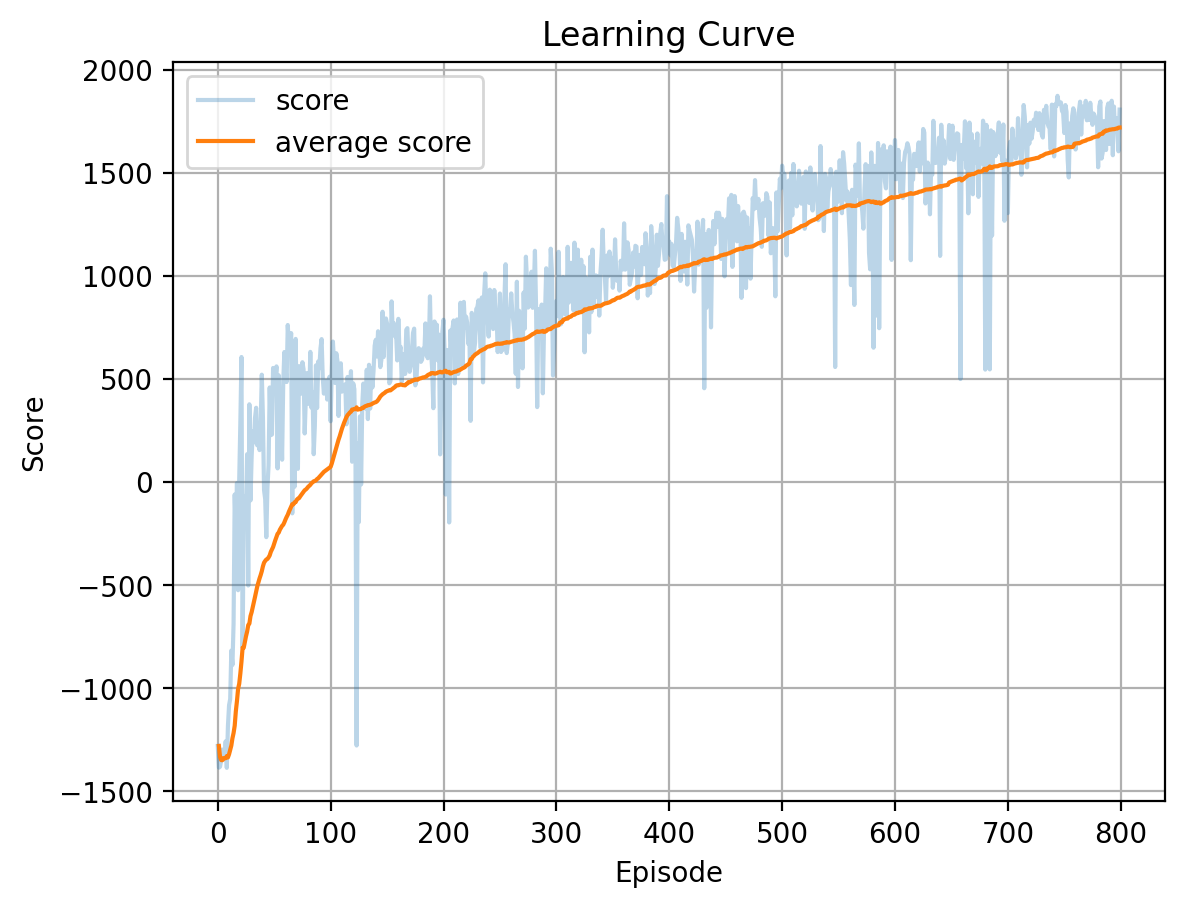

In [8]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
os.makedirs(dir_path, exist_ok=True)

if record_video:
    env = RecordVideo(env, video_folder=os.path.join(dir_path, 'videos'),
                      episode_trigger=lambda ep: ep == n_games - 1)
    
# Infer env specs
state_dims = env.observation_space.shape[0]
action_dims = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

agent = Agent(gamma=gamma, alpha=alpha, beta=beta, state_dims=state_dims, action_dims=action_dims,
              max_action=max_action, fc1_dim=fc1_dim, fc2_dim=fc2_dim, memory_size=memory_size,
              batch_size=batch_size, tau=tau, update_period=update_period, reward_scale=reward_scale,
              warmup=warmup, reparam_noise_lim=reparam_noise_lim, name='SAC', ckpt_dir=dir_path)

# Initialize performance tracking variables
scores = []
best_score = -np.inf
avg_score = 0

for game in trange(n_games):
    # Reset environment and initialize variables at the start of each episode
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    done = False
    score = 0

    # Interact with the environment until the episode is done
    while not done:
        action = agent.choose_action(state)
        step_out = env.step(action)
        if len(step_out) == 5:
            state_, reward, terminated, truncated, info = step_out
            done = terminated or truncated
        else:
            state_, reward, done, info = step_out
        
        agent.store_transition(state, action, reward * reward_scale, state_, done)
        agent.learn()
        
        state = state_
        score += reward

    # Track score and average score for plotting and saving
    scores.append(score)
    avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} | Learning iter: {agent.learn_iter:10.0f} |')


    # Save the model if the current avg score is better than the best so far
    if avg_score > best_score and game > 200:
        best_score = avg_score
        agent.save_model()

env.close()

plot_learning_curve(scores, agent.full_path)

## 🎥 Visualize Agent Behavior

This is the last episode recorded video of the trained agent interacting with the environment in training process.

In [9]:
Video(f"/content/tmp/HalfCheetahBulletEnv-v0/videos/rl-video-episode-{n_games-1}.mp4", embed=True, width=600)